Notebook purpose

- Document problems in MBD raw data

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [11]:
m = aws.S3BucketManager('3di-project-entropy')
m.list()

['3di-project-entropy/entropy_000.parquet',
 '3di-project-entropy/entropy_777.parquet',
 '3di-project-entropy/entropy_X77.parquet']

## 2020 drop in user numbers

Below uses pre-processed data for entropy project, but picture is the same for raw data.

In [3]:
df = aws.s3read_parquet('s3://3di-project-entropy/entropy_X77.parquet')

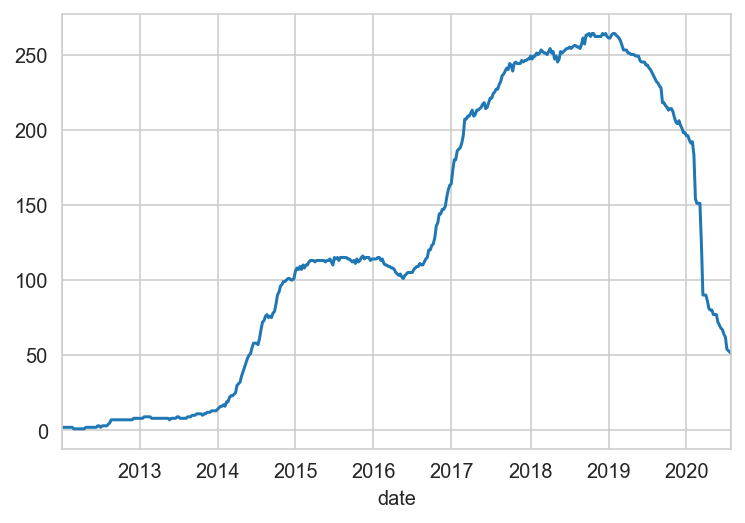

In [22]:
df.resample('w', on='date').agg({'user_id': 'nunique', 'account_id': 'nunique'}).user_id.plot();

Questions:

1. What account sfor the increase in users in 2014 and 2017? Simply widespread adoption?

2. What's behind the drop in 2019?

## Auto purpose tag inconsistency

Auto purpose tag should equal manual tag if manual tag is not missing and else equal Auto Purpose Tag. There are many cases where this is not the case.

### Case 1: incorrectly empty user precedence tag

In [3]:
df = aws.s3read_parquet('s3://3di-data-mdb/raw/mdb_777.parquet')
df.head(1)

,Transaction Reference,User Reference,User Registration Date,Year of Birth,Salary Range,Postcode,LSOA,MSOA,Derived Gender,Transaction Date,Account Reference,Provider Group Name,Account Type,Latest Recorded Balance,Transaction Description,Credit Debit,Amount,User Precedence Tag Name,Manual Tag Name,Auto Purpose Tag Name,Merchant Name,Merchant Business Line,Account Created Date,Account Last Refreshed,Data Warehouse Date Created,Data Warehouse Date Last Updated,Transaction Updated Flag
0,688293,777,2011-07-20,1969.0,20K to 30K,WA1 4,E01012553,E02002603,M,2012-01-25,262916,NatWest Bank,Current,364.220001,"9572 24jan12 , tcs bowdon , bowdon gb - pos",Debit,25.030001,No Tag,No Tag,No Tag,No Merchant,Unknown Merchant,2011-07-20,2020-07-21 20:32:00,2014-07-18,2017-10-24,U


In [73]:
tag_names = ['User Precedence Tag Name', 'Manual Tag Name', 'Auto Purpose Tag Name']
tags = df[tag_names]

mask = ((tags['User Precedence Tag Name'] == 'No Tag')
        & ((tags['Auto Purpose Tag Name'] != 'No Tag') 
           | (tags['Manual Tag Name'] != 'No Tag')))
errors = tags[mask]
errors.head(3)

,User Precedence Tag Name,Manual Tag Name,Auto Purpose Tag Name
33,No Tag,No Tag,Cash
36,No Tag,No Tag,Interest charges
37,No Tag,No Tag,Lunch or Snacks


In [74]:
print(f'Tags are incorrect in {len(errors) / len(df):.1%} percent of observations.')

Tags are incorrect in 8.9% percent of observations.


### Case 2: incorrectly empty manual and auto purpose tag

In [76]:
mask = ((tags['User Precedence Tag Name'] != 'No Tag')
        & (tags['Auto Purpose Tag Name'] == 'No Tag') 
        & (tags['Manual Tag Name'] == 'No Tag'))
errors = tags[mask]
errors.head(2)

,User Precedence Tag Name,Manual Tag Name,Auto Purpose Tag Name
507,Financial - other,No Tag,No Tag
590,Water,No Tag,No Tag


In [77]:
print(f'Tags are incorrect in {len(errors) / len(df):.1%} percent of observations.')

Tags are incorrect in 0.4% percent of observations.


### Correction

In [6]:
def correct_tag_up(df):
    """Set tag_up to tag_manual if tag_manual not missing else to tag_auto.
    
    This definition of tag_up is violated in two ways: sometimes tag_up is
    missing while one of the other two tags isn't, sometimes tag_up is
    not missing but both other tags are. In the latter case, we leave tag_up
    unchanged.
    """
    correct_up_value = df.tag_manual.fillna(df.tag_auto)
    df['tag_up'] = (df.tag_up.where(df.tag_up.notna(), correct_up_value))
    return df

## Duplicate transactions

In [127]:
df = aws.s3read_parquet('s3://3di-project-entropy/entropy_X77.parquet')

### Case studies

Most transactions below seem to be duplicated. How is this possible? How can we check/correct for it?

In [107]:
df.loc[df.user_id == 35177].set_index('date').loc['1 Jan 2020'][:20]

,id,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance,income
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,672667040,35177,866.00,<mdbremoved>,NaN,nan,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2017-05-25,724235,2020-08-14 20:59:00,hsbc,current,2020-01-03,1900-01-01,True,844.299988,non merchant mbl,NaN,NaN,NaN,202001,-721.219604,37692.274554
2020-01-01,681780726,35177,3.20,tfl travel ch tfl.gov.uk/cp gb - tfl travel ch,tfl,public transport,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2016-04-24,558493,2020-03-11 23:17:00,hsbc,credit card,2020-01-12,1900-01-01,True,-6698.250000,tfl,public transport,NaN,public transport,202001,-6967.069824,37692.274554
2020-01-01,681780725,35177,1.50,co-op group food london w12 gb - co-op group food,co-op,"food, groceries, household",False,xxxx 0,2014-02-14,20k to 30k,1990.0,2016-04-24,558493,2020-03-11 23:17:00,hsbc,credit card,2020-01-12,1900-01-01,True,-6698.250000,co-op supermarket,"food, groceries, household",NaN,"food, groceries, household",202001,-6967.069824,37692.274554
2020-01-01,681780723,35177,10.75,eagle london gb - eagle,NaN,nan,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2016-04-24,558493,2020-03-11 23:17:00,hsbc,credit card,2020-01-12,1900-01-01,True,-6698.250000,NaN,NaN,NaN,NaN,202001,-6967.069824,37692.274554
2020-01-01,681780724,35177,11.15,eagle london gb - eagle,NaN,nan,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2016-04-24,558493,2020-03-11 23:17:00,hsbc,credit card,2020-01-12,1900-01-01,True,-6698.250000,NaN,NaN,NaN,NaN,202001,-6967.069824,37692.274554
2020-01-01,806077736,35177,11.15,eagle <mdbremoved>,NaN,nan,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2020-08-11,1731987,2020-08-14 20:59:00,hsbc,credit card,2020-08-12,1900-01-01,True,-6909.620117,NaN,NaN,NaN,NaN,202001,-6930.949707,37692.274554
2020-01-01,806077737,35177,10.75,eagle <mdbremoved>,NaN,nan,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2020-08-11,1731987,2020-08-14 20:59:00,hsbc,credit card,2020-08-12,1900-01-01,True,-6909.620117,NaN,NaN,NaN,NaN,202001,-6930.949707,37692.274554
2020-01-01,806081025,35177,900.00,balance transfer,NaN,transfers,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2020-08-11,1731991,2020-08-14 21:00:00,marks & spencer,credit card,2020-08-12,1900-01-01,True,-3213.429932,personal,transfers,NaN,transfers,202001,-3812.719482,37692.274554
2020-01-01,806081026,35177,26.10,balance transfer <mdbremoved>,NaN,transfers,False,xxxx 0,2014-02-14,20k to 30k,1990.0,2020-08-11,1731991,2020-08-14 21:00:00,marks & spencer,credit card,2020-08-12,1900-01-01,True,-3213.429932,personal,transfers,NaN,transfers,202001,-3812.719482,37692.274554


In [108]:
df.loc[df.user_id == 362977].set_index('date').loc['1 Jan 2020'][:20]

,id,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance,income
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,672900827,362977,1.280000,"card payment to paybyphone re: barnet on,1.28 gbp, rate 1.00/gbp on xx-xx-2019",vwfs,parking,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624558,2020-08-16 12:06:00,santander,current,2020-01-03,1900-01-01,True,16629.380859,vwfs,parking,NaN,parking,202001,33337.257812,76201.198661
2020-01-01,672415668,362977,10.100000,"card payment to willows activity farm,10.10 gbp, rate 1.00/gbp on xx-xx-2019",NaN,nan,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624558,2020-08-16 12:06:00,santander,current,2020-01-03,1900-01-01,True,16629.380859,NaN,NaN,NaN,NaN,202001,33337.257812,76201.198661
2020-01-01,672487189,362977,3.500000,"card payment to balady,3.50 gbp, rate 1.00/gbp on xx-xx-2019",NaN,nan,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624558,2020-08-16 12:06:00,santander,current,2020-01-03,1900-01-01,True,16629.380859,NaN,NaN,NaN,NaN,202001,33337.257812,76201.198661
2020-01-01,672965985,362977,7.200000,"card payment to willows activity farm,7.20 gbp, rate 1.00/gbp on xx-xx-2019",NaN,nan,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624558,2020-08-16 12:06:00,santander,current,2020-01-03,1900-01-01,True,16629.380859,NaN,NaN,NaN,NaN,202001,33337.257812,76201.198661
2020-01-01,673263612,362977,23.200001,"card payment to willows activity farm,23.20 gbp, rate 1.00/gbp on xx-xx-2019",NaN,nan,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624558,2020-08-16 12:06:00,santander,current,2020-01-03,1900-01-01,True,16629.380859,NaN,NaN,NaN,NaN,202001,33337.257812,76201.198661
2020-01-01,673378076,362977,30.350000,"card payment to balady,30.35 gbp, rate 1.00/gbp on xx-xx-2019",NaN,nan,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624558,2020-08-16 12:06:00,santander,current,2020-01-03,1900-01-01,True,16629.380859,NaN,NaN,NaN,NaN,202001,33337.257812,76201.198661
2020-01-01,673825826,362977,9.750000,which?-moto-recurring t london,which,books / magazines / newspapers,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624759,2020-03-12 09:48:00,american express,credit card,2020-01-04,1900-01-01,True,-3445.270020,which,books / magazines / newspapers,NaN,books / magazines / newspapers,202001,-11784.491211,76201.198661
2020-01-01,674374257,362977,7.990000,audible uk adbl.co/pymt,audible,books / magazines / newspapers,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624759,2020-03-12 09:48:00,american express,credit card,2020-01-04,1900-01-01,True,-3445.270020,audible,books / magazines / newspapers,NaN,books / magazines / newspapers,202001,-11784.491211,76201.198661
2020-01-01,674573429,362977,107.949997,paypal *salmadreamw eba xxxxxx7733,paypal,enjoyment,False,nw2 2,2016-11-14,20k to 30k,1985.0,2016-11-14,624759,2020-03-12 09:48:00,american express,credit card,2020-01-04,1900-01-01,True,-3445.270020,paypal,enjoyment,NaN,enjoyment,202001,-11784.491211,76201.198661


In [109]:
df.loc[df.user_id == 467877].set_index('date').loc['1 Jan 2020']

,id,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance,income
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,674929767,467877,91.75,myprotein.com xxxxxxx9889,myprotein.com,"hairdressing, health, other",False,bs4 3,2018-10-21,30k to 40k,1988.0,2019-07-14,1356546,2020-03-11 17:45:00,american express,credit card,2020-01-05,1900-01-01,True,-1547.310059,myprotein.com,"hairdressing, health, other",NaN,"hairdressing, health, other",202001,-2695.730225,25255.063058
2020-01-01,674929766,467877,11.86,mike guerin - <mdbremoved> ' bristol,NaN,transfers,False,bs4 3,2018-10-21,30k to 40k,1988.0,2019-07-14,1356546,2020-03-11 17:45:00,american express,credit card,2020-01-05,1900-01-01,True,-1547.310059,NaN,transfers,NaN,transfers,202001,-2695.730225,25255.063058
2020-01-01,675722354,467877,25.00,bristol city council bristol gbr,NaN,council tax,False,bs4 3,2018-10-21,30k to 40k,1988.0,2018-10-21,1081233,2020-06-10 09:10:00,sainsburys,credit card,2020-01-06,1900-01-01,True,-318.260010,NaN,council tax,NaN,council tax,202001,-518.460938,25255.063058
2020-01-01,675722353,467877,282.50,"www.ralphlauren.co.uk chadderton, old",ralph lauren,clothes - designer or other,False,bs4 3,2018-10-21,30k to 40k,1988.0,2019-07-14,1356546,2020-03-11 17:45:00,american express,credit card,2020-01-06,2020-01-18,True,-1547.310059,ralph lauren,clothes - designer or other,NaN,clothes - designer or other,202001,-2695.730225,25255.063058
2020-01-01,760914427,467877,11.86,mike guerin - <mdbremoved> ' bristol,NaN,transfers,False,bs4 3,2018-10-21,30k to 40k,1988.0,2020-04-19,1671779,2020-08-16 10:20:00,american express,credit card,2020-04-20,1900-01-01,True,-1107.729980,NaN,transfers,NaN,transfers,202001,-2962.080322,25255.063058
2020-01-01,760910751,467877,91.75,myprotein.com xxxxxxx9889,myprotein.com,"hairdressing, health, other",False,bs4 3,2018-10-21,30k to 40k,1988.0,2020-04-19,1671779,2020-08-16 10:20:00,american express,credit card,2020-04-20,1900-01-01,True,-1107.729980,myprotein.com,"hairdressing, health, other",NaN,"hairdressing, health, other",202001,-2962.080322,25255.063058
2020-01-01,760916217,467877,282.50,"www.ralphlauren.co.uk chadderton, old",ralph lauren,clothes - designer or other,False,bs4 3,2018-10-21,30k to 40k,1988.0,2020-04-19,1671779,2020-08-16 10:20:00,american express,credit card,2020-04-20,2020-04-22,True,-1107.729980,ralph lauren,clothes - designer or other,NaN,clothes - designer or other,202001,-2962.080322,25255.063058
2020-01-01,788887525,467877,5.45,portwell place( <mdbremoved> bristol gbr,NaN,transfers,False,bs4 3,2018-10-21,30k to 40k,1988.0,2020-06-14,1708333,2020-08-16 09:37:00,sainsburys,credit card,2020-06-15,2020-06-16,True,-828.239990,NaN,transfers,NaN,transfers,202001,-192.179916,25255.063058


### Exploration

#### Prevalance

How prevalent are duplicates?

In [129]:
df['dup'] = df.duplicated(['date', 'user_id', 'account_id', 'amount'])
print('About {:.1%} of transactions are potential duplicates'.format(len(df[df.dup]) / len(df)))

About 3.6% of transactions are potential duplicates


In [7]:
d = df[df.duplicated(['date', 'user_id', 'amount'])]
print('If we don\'t require the txns to be on the same account id (to allow for duplicate accounts), about {:.1%} of transactions are potential duplicates'.format(len(d) / len(df)))

If we don't require the txns to be on the same account id (to allow for duplicate accounts), about 6.6% of transactions are potential duplicates


For now, I focus on duplicates on the same account. What percentage of users is affected?

In [8]:
print('{:.1%} of users have potential dups'.format(df[df.dup].user_id.nunique() / df.user_id.nunique()))

99.5% of users have potential dups


Suggests that problem is not limited to a small number of users or banks but is a MDB wide problem. What account types are affected?

In [9]:
df[df.dup].account_type.value_counts() / df.account_type.value_counts() * 100

current        3.783832
credit card    1.916685
savings        2.708652
other          3.554517
Name: account_type, dtype: float64

#### Txns value

In [36]:
def distr(x):
    pcts = [.01, .05, .1, .25, .50, .75, .90, .95, .99]
    return x.describe(percentiles=pcts).round(2)

distr(df[df.dup].amount)

count    46466.00
mean         8.33
std        483.72
min     -50000.00
1%        -630.00
5%         -40.00
10%         -5.00
25%          2.08
50%          8.00
75%         20.00
90%         50.00
95%        100.00
99%        500.00
max      22000.00
Name: amount, dtype: float64

Amounts are small, but roughly in line with distribution of all amounts (not shown), and too large to likely be purchases that are actually made multiple times a day (e.g. coffee).

What's the distribution of the percentage of txns per user that are potentials dups? 

In [37]:
distr(df.groupby('user_id').dup.mean().mul(100))

count    429.00
mean       3.14
std        3.62
min        0.00
1%         0.33
5%         0.63
10%        0.94
25%        1.45
50%        2.27
75%        3.47
90%        5.60
95%        7.92
99%       16.80
max       40.66
Name: dup, dtype: float64

Most users have very few potential duplicates. What's the distribution of the (net) value of txns per user that are potentials dups? 

In [46]:
distr(df[df.dup].groupby('user_id').amount.sum())

count      427.00
mean       906.30
std       5876.85
min     -53761.48
1%      -23134.61
5%       -3303.66
10%       -676.34
25%         72.09
50%        586.61
75%       1856.00
90%       4472.63
95%       7261.75
99%      19641.35
max      25061.96
Name: amount, dtype: float64

Above means that for 25% of users, duplicates skew their expensitures by more than £1856, which is substantial. Overall, most people appear poorer than they are.

What's the distribution of the (absolute) value of txns that are potentials dups?

In [47]:
distr(df[df.dup].set_index('user_id').amount.abs().groupby('user_id').sum())

count       427.00
mean       7050.57
std       20809.92
min           3.39
1%           36.13
5%           99.44
10%         205.18
25%         708.23
50%        1910.65
75%        5486.70
90%       13694.83
95%       21553.62
99%       82564.29
max      232748.36
Name: amount, dtype: float64

What transactions tend to be duplicates?

In [130]:
df[df.dup].desc.value_counts(dropna=False)[:30]

<mdbremoved>                                 2719
<mdbremoved>                                  729
<mdbremoved> ft                               419
b365 moto                                     338
daily od fee                                  330
tfl travel ch     tfl.gov.uk/cp               273
<mdbremoved> - s/o                            248
tfl.gov.uk/cp     tfl travel ch               241
<mdbremoved> so                               222
tfl travel charge tfl.gov.uk/cp               177
paypal payment                                172
www.skybet.com cd 9317                        171
<mdbremoved> atm                              162
betfair.-purchase                             150
paypal payment - d/d                          148
bank giro credit ref <mdbremoved>             147
b365 cd 0159                                  147
daily od fee chg                              134
wilkes vending ser cd 2915 deb                134
<mdbremoved> fpi                              128


In [131]:
df[df.dup].tag.value_counts()

nan                       10940
transfers                  5850
cash                       3325
gambling                   3298
bank charges               3129
                          ...  
designer clothes              0
credit card repayment         0
salary or wages (main)        0
secured loan repayment        0
printing                      0
Name: tag, Length: 197, dtype: int64

In [126]:
df.tag.value_counts()

food, groceries, household        154
transfers                         124
enjoyment                          47
cash                               42
lunch or snacks                    42
bank charges                       27
credit card                        25
dining or going out                22
public transport                   22
entertainment, tv, media           18
dining and drinking                15
mobile                             15
clothes - everyday or work         12
fuel                               12
appearance                         12
gambling                           10
earnings_income                    10
cinema                              8
hairdressing, health, other         8
other_income                        8
parking                             8
refunded purchase                   8
taxi                                8
home                                7
interest charges                    7
insurance                           6
hotel/b&b   

In [53]:
df[df.desc == 'daily od fee'].sort_values(['user_id', 'date'])

,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance,income,dup
52071,280169301,2017-11-02,34677,0.31,daily od fee,NaN,bank charges,True,wf12 7,2014-02-10,NaN,1988.0,2014-02-10,133763,2020-03-11 20:32:00,halifax personal banking,current,2017-11-04,2018-04-30,True,350.540009,account provider,bank charges,NaN,bank charges,201711,-245.833008,32636.500000,False
52075,280779220,2017-11-03,34677,0.34,daily od fee,NaN,bank charges,True,wf12 7,2014-02-10,NaN,1988.0,2014-02-10,133763,2020-03-11 20:32:00,halifax personal banking,current,2017-11-06,2018-04-30,True,350.540009,account provider,bank charges,NaN,bank charges,201711,-266.973145,32636.500000,False
52081,281268590,2017-11-06,34677,0.40,daily od fee,NaN,bank charges,True,wf12 7,2014-02-10,NaN,1988.0,2014-02-10,133763,2020-03-11 20:32:00,halifax personal banking,current,2017-11-08,2018-04-30,True,350.540009,account provider,bank charges,NaN,bank charges,201711,-304.073242,32636.500000,False
52086,281736984,2017-11-07,34677,0.41,daily od fee,NaN,bank charges,True,wf12 7,2014-02-10,NaN,1988.0,2014-02-10,133763,2020-03-11 20:32:00,halifax personal banking,current,2017-11-09,2018-04-30,True,350.540009,account provider,bank charges,NaN,bank charges,201711,-316.483398,32636.500000,False
52088,282394934,2017-11-08,34677,0.42,daily od fee,NaN,bank charges,True,wf12 7,2014-02-10,NaN,1988.0,2014-02-10,133763,2020-03-11 20:32:00,halifax personal banking,current,2017-11-10,2018-04-30,True,350.540009,account provider,bank charges,NaN,bank charges,201711,-320.103516,32636.500000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293332,771163537,2020-04-02,583677,1.52,daily od fee,NaN,bank charges,True,pe23 5,2020-05-12,20k to 30k,1987.0,2020-05-12,1688682,2020-08-09 21:48:00,lloyds bank,current,2020-05-13,1900-01-01,True,-979.270020,account provider,bank charges,NaN,bank charges,202004,-1424.429810,49951.851562,False
1293333,771166984,2020-04-02,583677,3.18,daily od fee,NaN,bank charges,True,pe23 5,2020-05-12,20k to 30k,1987.0,2020-05-12,1688628,2020-08-09 22:03:00,lloyds bank,current,2020-05-13,1900-01-01,True,-2173.780029,account provider,bank charges,NaN,bank charges,202004,-1576.760132,49951.851562,False
1293335,771158028,2020-04-03,583677,2.11,daily od fee,NaN,bank charges,True,pe23 5,2020-05-12,20k to 30k,1987.0,2020-05-12,1688629,2020-08-09 22:03:00,lloyds bank,current,2020-05-13,1900-01-01,True,-1083.930054,account provider,bank charges,NaN,bank charges,202004,-1822.009766,49951.851562,False
1293336,771167831,2020-04-03,583677,1.53,daily od fee,NaN,bank charges,True,pe23 5,2020-05-12,20k to 30k,1987.0,2020-05-12,1688682,2020-08-09 21:48:00,lloyds bank,current,2020-05-13,1900-01-01,True,-979.270020,account provider,bank charges,NaN,bank charges,202004,-1425.959839,49951.851562,False


In [49]:
df[df.desc == 'b365 moto'].head()

,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance,income,dup
159699,30251924,2014-05-12,116877,10.0,b365 moto,bet365,gambling,False,pa8 6,2014-08-06,NaN,1983.0,2014-08-06,271510,2018-02-03 19:04:00,first direct,current,2014-08-07,2017-09-12,True,NaN,bet365,gambling,NaN,gambling account,201405,NaN,20243.504883,False
159702,30251925,2014-05-13,116877,5.0,b365 moto,bet365,gambling,False,pa8 6,2014-08-06,NaN,1983.0,2014-08-06,271510,2018-02-03 19:04:00,first direct,current,2014-08-07,2017-09-12,True,NaN,bet365,gambling,NaN,gambling account,201405,NaN,20243.504883,False
159703,30251926,2014-05-13,116877,10.0,b365 moto,bet365,gambling,False,pa8 6,2014-08-06,NaN,1983.0,2014-08-06,271510,2018-02-03 19:04:00,first direct,current,2014-08-07,2017-09-12,True,NaN,bet365,gambling,NaN,gambling account,201405,NaN,20243.504883,False
159711,30251936,2014-05-19,116877,10.0,b365 moto,bet365,gambling,False,pa8 6,2014-08-06,NaN,1983.0,2014-08-06,271510,2018-02-03 19:04:00,first direct,current,2014-08-07,2017-09-12,True,NaN,bet365,gambling,NaN,gambling account,201405,NaN,20243.504883,False
159726,30251948,2014-05-27,116877,20.0,b365 moto,bet365,gambling,False,pa8 6,2014-08-06,NaN,1983.0,2014-08-06,271510,2018-02-03 19:04:00,first direct,current,2014-08-07,2017-09-12,True,NaN,bet365,gambling,NaN,gambling account,201405,NaN,20243.504883,False


Two things above are strange: 1) why is net value of such few transactions so high? are dups dispropirtionally large txns? 2) Why are percentiles round numbers?

In [125]:
distr(df[df.dup].amount)

AttributeError: 'DataFrame' object has no attribute 'dup'

In [135]:
df[df.merchant.str.endswith('sco', na=False)]

,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance,income,dup
2,688263,2012-01-03,777,6.680000,"9572 31dec11 , tesco stores 3345 , warrington gb - pos",tesco,"food, groceries, household",False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-08-15,True,364.220001,tesco supermarket,"food, groceries, household",NaN,supermarket,201201,-1451.075562,24319.220881,False
3,688265,2012-01-03,777,12.000000,"9572 31dec11 , tesco stores 3345 , warrington gb - pos",tesco,"food, groceries, household",False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-08-15,True,364.220001,tesco supermarket,"food, groceries, household",NaN,supermarket,201201,-1451.075562,24319.220881,False
6,688267,2012-01-04,777,8.740000,"9572 03jan12 , tesco-stores sacat, sale gb - pos",tesco,"food, groceries, household",False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-08-15,True,364.220001,tesco supermarket,"food, groceries, household",NaN,groceries,201201,-1468.565552,24319.220881,False
11,688272,2012-01-11,777,6.100000,"9572 09jan12 , tesco-stores sacat, sale gb - pos",tesco,"food, groceries, household",False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-08-15,True,364.220001,tesco supermarket,"food, groceries, household",NaN,groceries,201201,-1719.905518,24319.220881,False
22,688282,2012-01-17,777,4.640000,"9572 16jan12 , tesco-stores sacat, sale gb - pos",tesco,"food, groceries, household",False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-08-15,True,364.220001,tesco supermarket,"food, groceries, household",NaN,groceries,201201,-2048.515625,24319.220881,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299483,788701479,2020-03-06,587177,3.850000,tesco store2097 cd 4914,tesco,"food, groceries, household",False,cm12 0,2020-06-13,30k to 40k,1964.0,2020-06-13,1708060,2020-08-16 11:46:00,tsb,current,2020-06-14,1900-01-01,True,3263.830078,tesco supermarket,"food, groceries, household",NaN,"food, groceries, household",202003,1912.260498,37865.039062,False
1299511,788701458,2020-03-17,587177,39.930000,tesco pfs 3967 cd 4914,tesco,fuel,False,cm12 0,2020-06-13,30k to 40k,1964.0,2020-06-13,1708060,2020-08-16 11:46:00,tsb,current,2020-06-14,1900-01-01,True,3263.830078,tesco fuel,fuel,NaN,fuel,202003,4775.360352,37865.039062,False
1299530,788701442,2020-03-24,587177,18.400000,tesco pfs 3885 cd 4914,tesco,fuel,False,cm12 0,2020-06-13,30k to 40k,1964.0,2020-06-13,1708060,2020-08-16 11:46:00,tsb,current,2020-06-14,1900-01-01,True,3263.830078,tesco fuel,fuel,NaN,fuel,202003,4088.760742,37865.039062,False
1299531,788701445,2020-03-24,587177,39.299999,tesco pay at pump 3987 cd 0010,tesco,fuel,False,cm12 0,2020-06-13,30k to 40k,1964.0,2020-06-13,1708060,2020-08-16 11:46:00,tsb,current,2020-06-14,1900-01-01,True,3263.830078,tesco fuel,fuel,NaN,fuel,202003,4088.760742,37865.039062,False
